# Re-implementation of GNLM in python

In [1]:
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import scipy.io
from typing import Tuple, List
from scipy.spatial import distance

print(jax.devices())

[cuda(id=0)]


In [2]:
@jax.jit
def cdist(x, y):
  return jnp.sqrt(jnp.sum((x[:, None] - y[None, :]) ** 2, -1))
  

def T(sar):
    sar = jnp.array(sar)
    sar = 20 * np.log1p(np.abs(sar))
    sar = (sar - sar.min()) / (sar.max() - sar.min())  # Normalize to [0, 1]
    if sar.ndim == 2:
        sar = jnp.expand_dims(sar, axis=-1)  # (H, W) -> (H, W, 1)
    return sar


def rgb2gray(rgb):
    """Convert RGB image to grayscale."""
    return jnp.dot(rgb[..., :3], jnp.array([1./3.] * 3))

2025-08-21 19:10:56.227186: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.8 which is older than the ptxas CUDA version (12.9.86). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


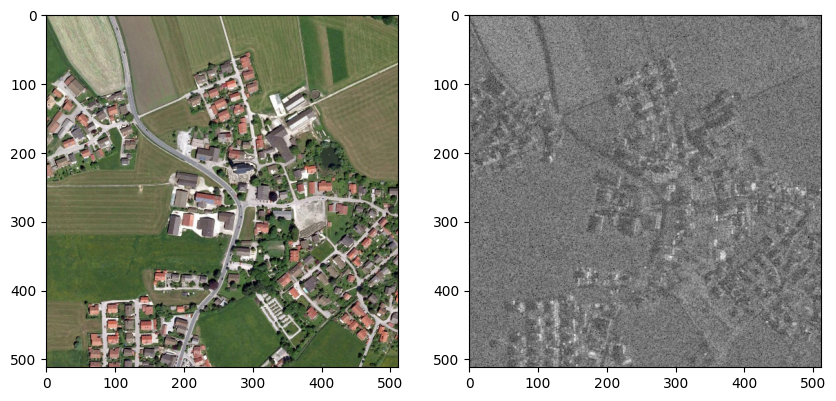

In [3]:
input_path = "../../dataset/clip_T1.mat"
data = scipy.io.loadmat(input_path)

guide = data['guide']
noisy = data['noisy']

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(guide)
plt.subplot(1, 2, 2)
plt.imshow(T(noisy), cmap='gray')

In [4]:
def compute_distance_opt(patch_opt_t: jnp.ndarray, patch_opt_s: jnp.ndarray) -> float:
    assert patch_opt_t.shape == patch_opt_s.shape, "Patches must have the same shape"
    assert patch_opt_t.ndim == 3, "Patches must be 3D (H, W, C)"

    M = patch_opt_t.shape[-1]  # Number of bands
    N = patch_opt_t.shape[0] * patch_opt_t.shape[1]  # Patch size
    return jnp.sum((patch_opt_t - patch_opt_s) ** 2) / (M * N)


def compute_distance_sar(patch_sar_t: jnp.ndarray, patch_sar_s: jnp.ndarray) -> float:  # Implement mu_D
    assert patch_sar_t.shape == patch_sar_s.shape, "Patches must have the same shape"
    assert patch_sar_t.ndim == 2, "Patches must be 2D (H, W)"

    numerator = patch_sar_t + patch_sar_s
    denominator = patch_sar_t * patch_sar_s
    mask = denominator != 0
    N = mask.sum()  
    dist = jnp.log(0.5 * numerator[mask] / jnp.sqrt(denominator[mask]))
    return jnp.sum(dist) / N


def compute_weights(
    patch_sar_t: jnp.ndarray, 
    patch_sar_s: jnp.ndarray, 
    patch_opt_t: jnp.ndarray, 
    patch_opt_s: jnp.ndarray, 
    lmbda: float, 
    gamma: float) -> jnp.ndarray:
    assert 0 <= gamma <= 1, "Gamma must be in the range [0, 1]"

    ds = compute_distance_sar(patch_sar_t, patch_sar_s)
    do = compute_distance_opt(patch_opt_t, patch_opt_s)
    dist = jnp.exp(-lmbda * (gamma * ds + (1 - gamma) * do))
    return dist / jnp.sum(dist)  # Normalize weights to sum to 1


def extract_patches(
        tensor: jnp.ndarray, 
        kernel_size: int,
        start_index: Tuple[int, int],
        end_indices: Tuple[int, int]) -> jnp.ndarray:
    """
    Extracts sliding patches from a 2D or 3D tensor.
    This function is designed to be memory efficient by extracting patches only within the specified indices.

    Parameters:
    tensor: 
        Input tensor of size (H, W, D) or (H, W)
    kernel_size: int
        Size of the square kernel (must be odd).
    start_index: Tuple[int, int]
        Starting indices for the patch extraction.
    end_indices: Tuple[int, int]
        Ending indices for the patch extraction.
    Returns: 
    jnp.ndarray
        A tensor of size (H', W', kernel_size, kernel_size, D) or (H', W', kernel_size, kernel_size) containing the extracted patches,
        where H' and W' are the dimensions defined by the start and end indices.
    """
    D = tensor.shape[2:]  # Tuple corresponding to the size of the descriptor, which can be empty if input tensor is 2D
    pad = kernel_size // 2  # Integer, the pad size usually corresponds to half the size of the kernel

    # Create indices for the sliding window
    h_idx = jnp.arange(start_index[0], end_indices[0])
    w_idx = jnp.arange(start_index[1], end_indices[1])

    # Create a function to extract patches for each (i, j) pair
    def get_patch(i: int, j: int) -> jnp.ndarray:
        patch = jax.lax.dynamic_slice(operand=tensor, 
                                      start_indices=(i, j) + (0,)*len(D), 
                                      slice_sizes=(kernel_size, kernel_size) + D)
        return patch

    # Use vmap to vectorize the extraction of patches across the height and width indices
    patches = jax.vmap(
        lambda i: jax.vmap(lambda j: get_patch(i, j))(w_idx)
    )(h_idx)
    return patches 


def compute_indices_from_n_blocks(
        n_blocks: int, 
        H: int, 
        W: int,
) -> Tuple[List[Tuple[int, int]], List[Tuple[int, int]]]:
    """
    Computes the starting and ending indices for extracting patches from a tensor.
    
    Returns:
    Tuple[List[Tuple[int, int]], List[Tuple[int, int]]]
        Starting and ending indices for patch extraction.
    """
    # Compute the split points along each dimension
    h_edges = np.linspace(0, H, n_blocks + 1, dtype=int)
    w_edges = np.linspace(0, W, n_blocks + 1, dtype=int)

    # Generate all combinations of start and end indices
    start_indices = []
    end_indices = []
    for i in range(n_blocks):
        for j in range(n_blocks):
            start = (h_edges[i], w_edges[j])
            end = (h_edges[i+1], w_edges[j+1])
            start_indices.append(start)
            end_indices.append(end)
    return start_indices, end_indices


In [10]:
start_indices, end_indices = compute_indices_from_n_blocks(n_blocks=25, H=noisy.shape[0], W=noisy.shape[1])

In [11]:
start_index, end_index = start_indices[0], end_indices[0]
kernel_size = 39

sar_patches = extract_patches(noisy, kernel_size, start_index, end_index)  # (H', W', k, k, 1)
guide_patches = extract_patches(guide, kernel_size, start_index, end_index)  # (H', W', k, k, 3)

print(f"Extracted patches shape: {sar_patches.shape}, {guide_patches.shape}")

Extracted patches shape: (20, 20, 39, 39), (20, 20, 39, 39, 3)


In [19]:
sar_patches.reshape(-1, kernel_size * kernel_size).shape

(400, 1521)

In [21]:
distance_matrix_sar = distance.cdist(
    sar_patches.reshape(-1, kernel_size * kernel_size).T, 
    sar_patches.reshape(-1, kernel_size * kernel_size).T
)

distance_matrix_sar.shape

(1521, 1521)

In [ ]:
# find positions of the 10 maximum distances
max_indices = jnp.argsort(distance_matrix_sar, axis=None)[-10:]
max_indices_2d = jnp.unravel_index(max_indices, distance_matrix_sar.shape)
max_indices_2d

(Array([  93, 1014,   55,  976,  287, 1287,   92, 1014,   54,  975], dtype=int32),
 Array([1014,   93,  976,   55, 1287,  287, 1014,   92,  975,   54], dtype=int32))

In [25]:
predictor_sar_patches = sar_patches[..., max_indices_2d[0], max_indices_2d[1]]
predictor_sar_patches.shape

(20, 20, 10)

In [26]:
estimates_sar = jnp.mean(predictor_sar_patches, axis=-1)  # Average the selected patches
estimates_sar.shape

(20, 20)

In [ ]:
sar = T(noisy) 
sar_filtered = jnp.zeros_like(sar)  # Initialize the filtered SAR image
kernel_size = 39

progress_bar = tqdm(total=len(start_indices), desc="Despeckling", unit="block")
for start_index, end_index in zip(start_indices, end_indices):
    sar_patches = extract_patches(sar, kernel_size, start_index, end_index)  # (H', W', k, k, 1)
    guide_patches = extract_patches(guide, kernel_size, start_index, end_index)  # (H', W', k, k, 3)

    distance_matrix_sar = distance.cdist(
        sar_patches.reshape(-1, kernel_size * kernel_size).T, 
        sar_patches.reshape(-1, kernel_size * kernel_size).T
    )

    max_indices = jnp.argsort(distance_matrix_sar, axis=None)[-10:]
    max_indices_2d = jnp.unravel_index(max_indices, distance_matrix_sar.shape)

    predictor_sar_patches = sar_patches[..., max_indices_2d[0], max_indices_2d[1]]
    estimates_sar = jnp.mean(predictor_sar_patches, axis=-1)  # Average the selected patches

    # Filtering
    update_block = (weights * sar_patches).sum(axis=(-3, -2))  # (H', W', 1)

    # Update only the current block
    sar_filtered = jax.lax.dynamic_update_slice(sar_filtered, update_block, start_index + (0,))  
    progress_bar.update(1)
progress_bar.close()

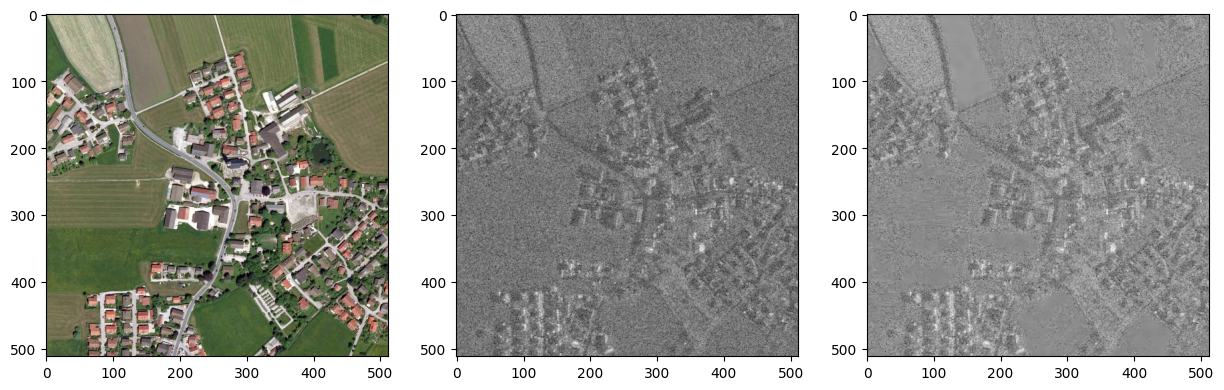

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(guide)
plt.subplot(1, 3, 2)
plt.imshow(T(noisy), cmap='gray')
plt.subplot(1, 3, 3)
plt.imshow(T(sar_filtered), cmap='gray')